In [108]:
from monk import workflow, utils
import signac
import glob
import gsd.hoomd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import freud
from schmeud import _schmeud

In [11]:
root = "/media/ian/Data2/monk/2d-esl"
project: signac.Project = signac.get_project(root)

In [12]:
for job in project:
    pot = job.sp.pot
    if pot == "KA_WCA":
        continue
    print(job.sp)
    files = glob.glob(job.fn("fixed-fine-equil/*.gsd"))
    sf_files = glob.glob(job.fn("fixed-analysis/*.parquet"))

    # for file in sorted(files):

    break

{'N': 32768, 'replica': 0, 'rho': 1.2, 'pot': 'KA_LJ'}


In [13]:
job

Job(project=Project.get_project('/media/ian/Data2/monk/2d-esl'), statepoint={'N': 32768, 'replica': 0, 'rho': 1.2, 'pot': 'KA_LJ'})

In [14]:
files

['/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.300.gsd',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.562.gsd',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.487.gsd',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.450.gsd',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.525.gsd',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.675.gsd',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.637.gsd',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.337.gsd',
 '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equ

In [15]:
traj = gsd.hoomd.open(files[0])

In [16]:
df = pd.read_parquet(sf_files[-2])

In [17]:
idx = df["phop"].idxmax()
idx, df["phop"].max(), df["phop"].iloc[idx]

(523245, 0.77597564, 0.77597564)

In [18]:
df.iloc[idx]

frame                                                  750
tag                                                  31725
type                                                     1
phop                                              0.775976
sf       [0.0, 0.0, 0.0, 0.0, 0.09901873, 0.0, 0.906714...
Name: 523245, dtype: object

In [20]:
project.doc

{'avail_seed': 11, 'dt': 0.005, 'step_unit': 1000, 'temp_steps': 20, 'equil_time': 40, 'run_time': 10, 'max_alpha_time': 1000, 'alpha_iters': 10, '_status': {}}

In [21]:
runs = glob.glob(job.fn("fixed-analysis/fire_temp-*0.300.gsd"))
for run in runs:
    print(run)
    traj = gsd.hoomd.open(run)
    ref_snap = traj[0]
    ref_pos = ref_snap.particles.position.copy()
    box = freud.box.Box.from_box(ref_snap.configuration.box)
    pos_shape = ref_pos.shape
    pos = np.zeros((200, *pos_shape), dtype=np.float32)
    pos[0] = ref_pos
    for i, snap in enumerate(traj[1:200]):
        next_pos = snap.particles.position.copy()
        pos[i+1] = box.wrap(next_pos - ref_pos) + pos[i]
        ref_pos = next_pos

    # compute phop
    print("Computing phop")
    phop = _schmeud.dynamics.p_hop(pos, 101)
    break

/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-analysis/fire_temp-0.300.gsd
Computing phop


In [22]:
np.argwhere(phop > 0.7)

array([[   0, 8441],
       [   1, 8441],
       [  32, 2939],
       [  33, 2939],
       [  34, 2939],
       [  63, 2367],
       [  64, 2367],
       [  65, 2367],
       [  66, 2367],
       [  67, 2367],
       [  68, 2367]])

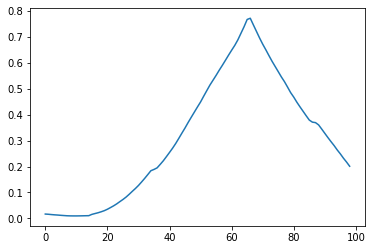

In [23]:
plt.plot(phop[:,2367])

In [24]:
np.argmax(phop[:,2367])

66

In [25]:
x = pos[:200,2367, 0]
y = pos[:200,2367, 1]

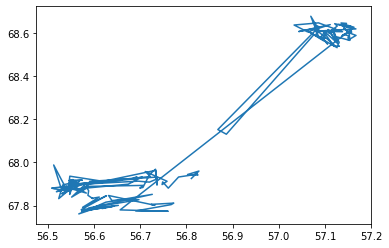

In [26]:
plt.plot(x, y)

In [53]:
thermal_equils = glob.glob(job.fn("fixed-fine-equil/equil_temp-*0.300.gsd"))
for run in thermal_equils:
    print(run)
    traje = gsd.hoomd.open(run)
    ref_snap = traje[0]
    ref_pos = ref_snap.particles.position.copy()
    orig_pos = ref_pos.copy()
    box = freud.box.Box.from_box(ref_snap.configuration.box)
    pos_shape = ref_pos.shape
    pose = np.zeros((300, *pos_shape), dtype=np.float32)
    pose[0] = ref_pos
    for i, snap in enumerate(traje[1:300]):
        next_pos = snap.particles.position.copy()
        pose[i+1] = box.wrap(next_pos - ref_pos) + pose[i]
        ref_pos = next_pos

    break

/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/fixed-fine-equil/equil_temp-0.300.gsd


In [47]:
pos_shape

(32768, 3)

In [48]:
x = pose[:200,2367, 0]
y = pose[:200,2367, 1]

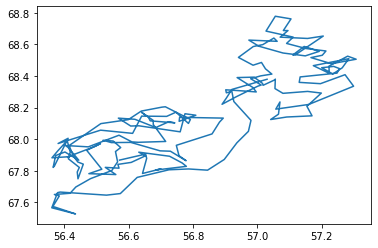

In [49]:
plt.plot(x, y)

In [30]:
# get neighbors around particle 2367

query = freud.locality.AABBQuery(box, ref_pos)
nlist = query.query(ref_pos[2367], {"r_max": 5}).toNeighborList()

In [31]:
nlist.point_indices

array([  138,   139,   322,   360,   667,   669,   864,  1057,  1247,
        1436,  1928,  1941,  2004,  2307,  2367,  2497,  2711,  2861,
        3225,  3383,  3559,  3576,  3957,  3979,  4126,  4129,  4174,
        4478,  4491,  4668,  4689,  4870,  4873,  5029,  5236,  5551,
        5746,  5967,  5991,  6008,  6467,  6650,  6712,  7256,  7411,
        7775,  7967,  7983,  8008,  8141,  9384, 10144, 10322, 11079,
       11984, 17660, 22172, 22608, 22888, 23786, 23978, 26726, 26734,
       26817, 27043, 27116, 27137, 27232, 27286, 27491, 28053, 28105,
       28695, 29081, 29306, 29411, 29848, 29970, 29973, 29986, 30012,
       30146, 30149, 30208, 30556, 30718, 31622, 31625, 31643, 31824,
       32022, 32133, 32243, 32366, 32587], dtype=uint32)

(64.37926483154297, 72.37926483154297)

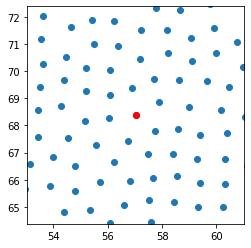

In [32]:
fig, ax = plt.subplots()
plt.scatter(ref_pos[nlist.point_indices, 0], ref_pos[nlist.point_indices, 1])
plt.scatter(ref_pos[2367, 0], ref_pos[2367, 1], c="r")
# ax = plt.gca()
ax.set_aspect("equal")
z = ref_pos[2367]
L = 4
plt.xlim(z[0] - L, z[0] + L)
plt.ylim(z[1] - L, z[1] + L)

In [109]:
from matplotlib import colors
from matplotlib import cm

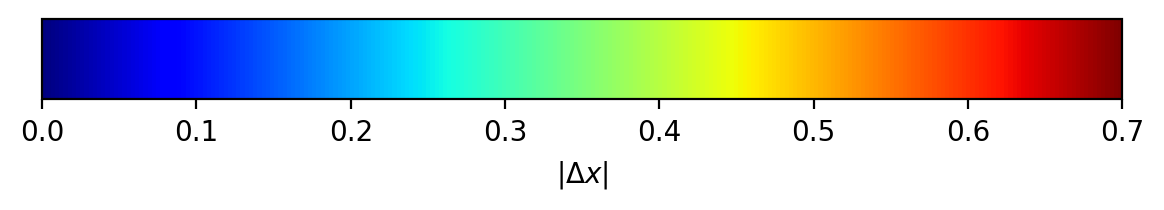

In [121]:
# import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(dpi=200)
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=colors.Normalize(vmin=0, vmax=0.7)), cax=ax, orientation='horizontal', label=r"$|\Delta x|$")

plt.savefig('just_colorbar', bbox_inches='tight')

/tmp/ipykernel_2127116/2779410439.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pose[i, nlist.point_indices, 0], pose[i, nlist.point_indices, 1], c=cmap(norm(i)), alpha=0.1, s=0.5)
/tmp/ipykernel_2127116/2779410439.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pose[i, 2367, 0], pose[i, 2367, 1], c=cmap(norm(i)), s=0.5)


(64.37926483154297, 72.37926483154297)

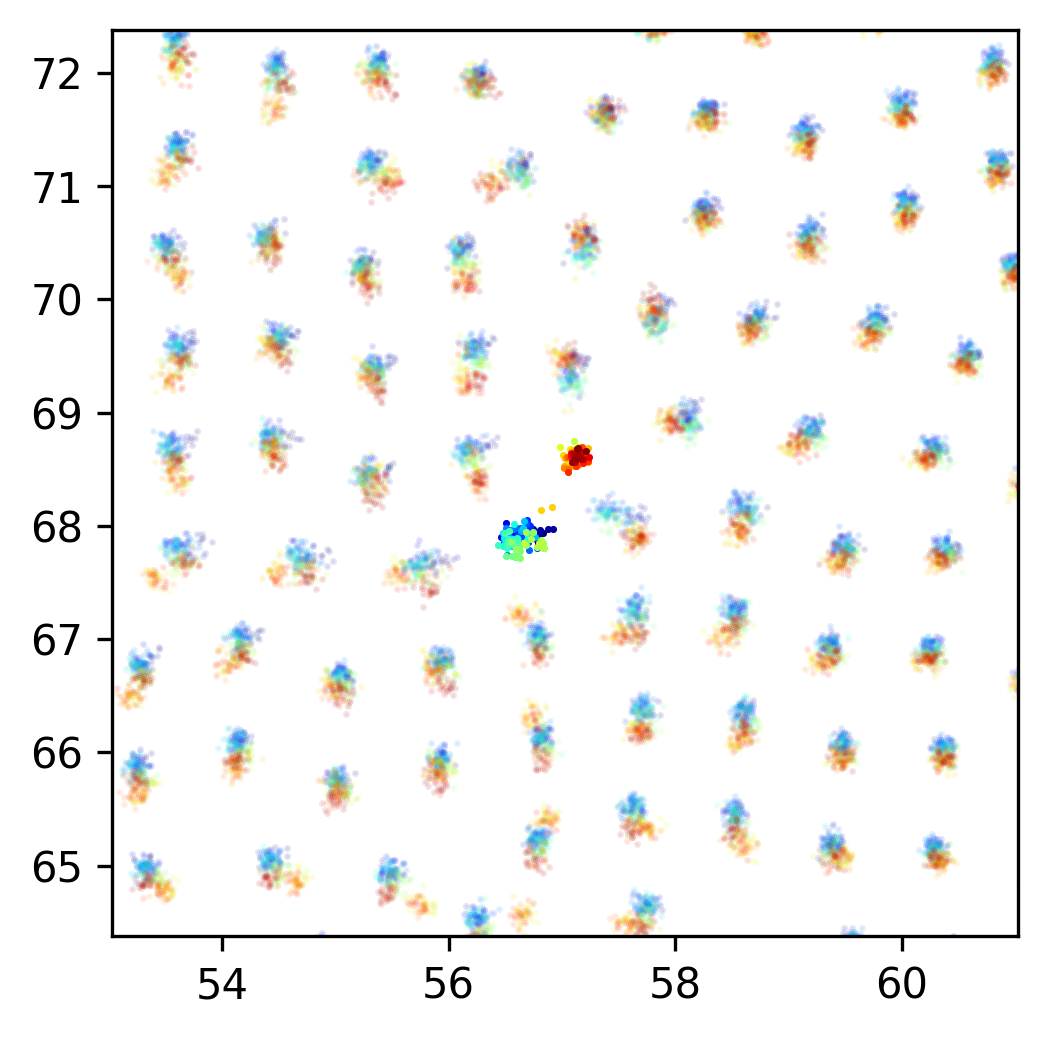

In [72]:
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")

cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=200)

for i in range(len(pose)):
    plt.scatter(pose[i, nlist.point_indices, 0], pose[i, nlist.point_indices, 1], c=cmap(norm(i)), alpha=0.1, s=0.5)
    plt.scatter(pose[i, 2367, 0], pose[i, 2367, 1], c=cmap(norm(i)), s=0.5)
    # plt.scatter(ref_pos[2367, 0], ref_pos[2367, 1], c=cmap(norm(i)))
    # ax = plt.gca()
    
z = ref_pos[2367]
L = 4
plt.xlim(z[0] - L, z[0] + L)
plt.ylim(z[1] - L, z[1] + L)

In [50]:
# get neighbors around particle 2367

query = freud.locality.AABBQuery(box, ref_pos)
nlist2 = query.query(ref_pos[2367], {"r_max": 5, "r_min": 0.05}).toNeighborList()

(65.37926483154297, 71.37926483154297)

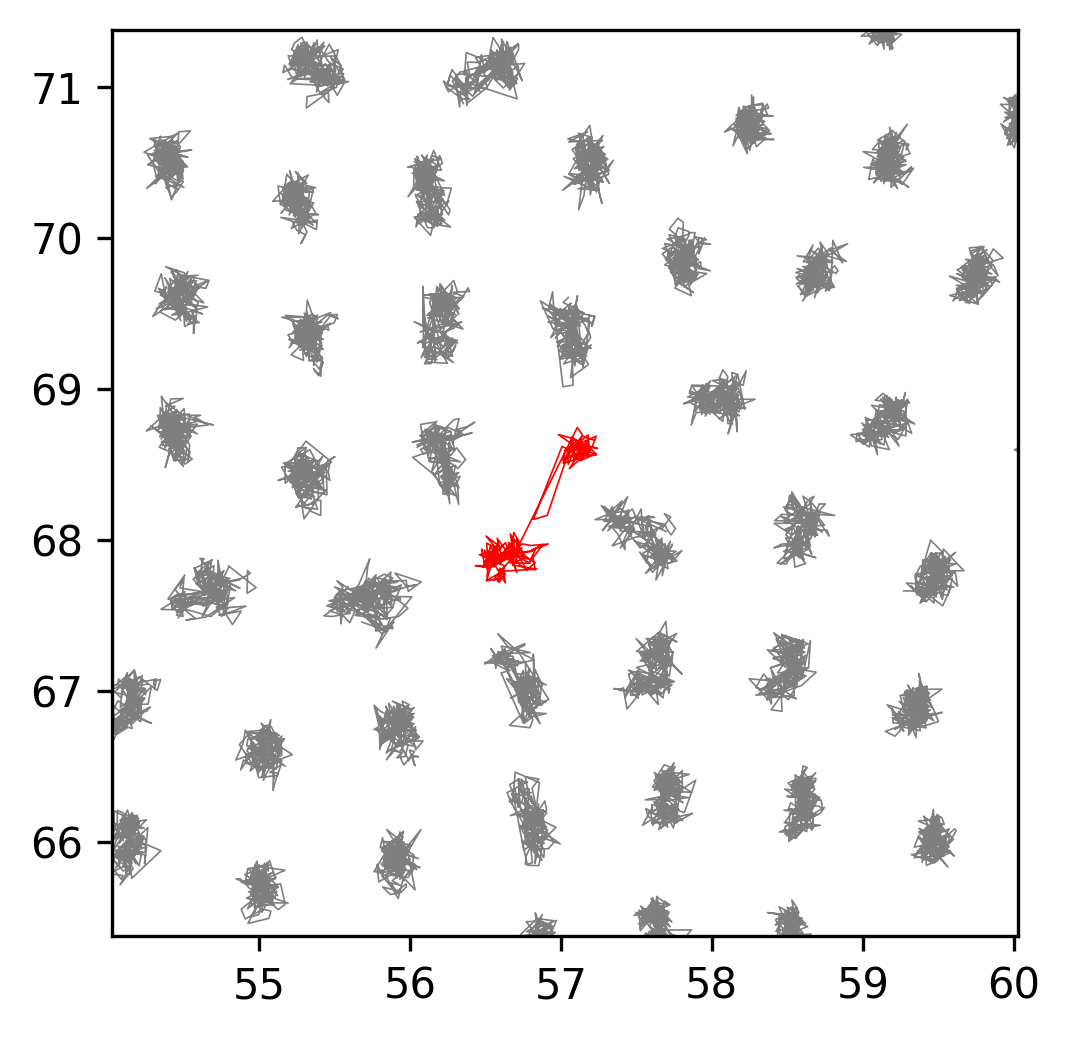

In [37]:
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")

cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=200)

# for i in range(len(pose)):
#     plt.(pose[i, nlist.point_indices, 0], pose[i, nlist.point_indices, 1], c=cmap(norm(i)), alpha=0.1, s=0.5)
#     plt.scatter(pose[i, 2367, 0], pose[i, 2367, 1], c=cmap(norm(i)), s=0.5)
    # plt.scatter(ref_pos[2367, 0], ref_pos[2367, 1], c=cmap(norm(i)))
    # ax = plt.gca()
lw = 0.4
plt.plot(pose[:, nlist2.point_indices, 0], pose[:, nlist2.point_indices, 1], c="k", lw=lw, alpha=0.5)
plt.plot(pose[:, 2367, 0], pose[:, 2367, 1], "-", lw=lw, color="r",)
    
z = ref_pos[2367]
L = 3
plt.xlim(z[0] - L, z[0] + L)
plt.ylim(z[1] - L, z[1] + L)

/tmp/ipykernel_4187809/939652516.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pose[i, 2367, 0], pose[i, 2367, 1], alpha=alpha, c=cmap(norm(diff)), s=s)


KeyboardInterrupt: 

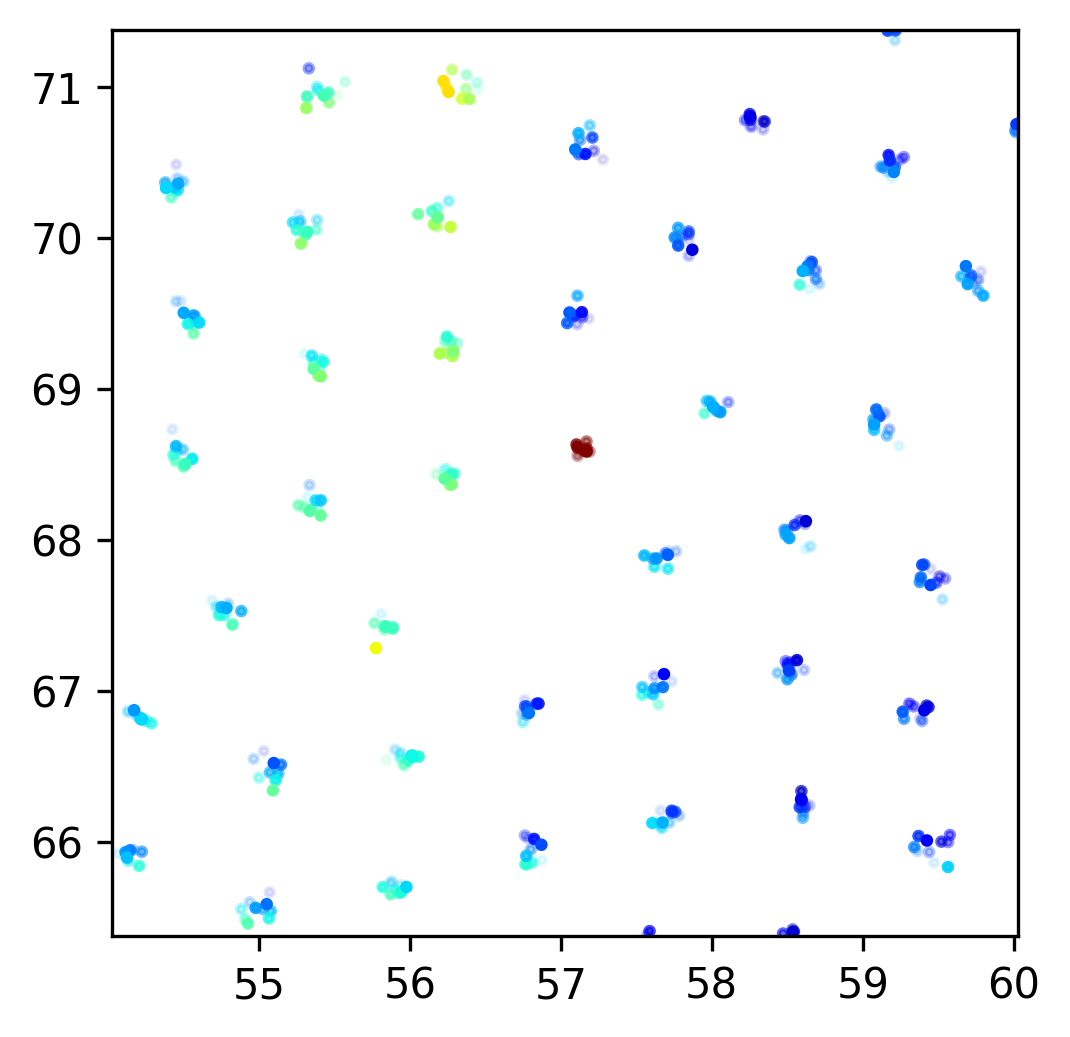

In [38]:
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")

cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=0.7)

z = ref_pos[2367]
L = 3
s = 4

for j in range(len(pose)):
    ax.clear()
    for i in np.arange(np.max([0, j-10]), j+1):
        alpha = 1 - (j - i) / 10
        
        diff = np.linalg.norm(pose[i, nlist2.point_indices] - pose[0, nlist2.point_indices], axis=-1)
        plt.scatter(pose[i, nlist2.point_indices, 0], pose[i, nlist2.point_indices, 1], c=cmap(norm(diff)), alpha=alpha, s=s)
        diff = np.linalg.norm(pose[i, 2367] - pose[0, 2367])
        plt.scatter(pose[i, 2367, 0], pose[i, 2367, 1], alpha=alpha, c=cmap(norm(diff)), s=s)
    
    # plt.scatter(ref_pos[2367, 0], ref_pos[2367, 1], c=cmap(norm(i)))
    # ax = plt.gca()
    plt.xlim(z[0] - L, z[0] + L)
    plt.ylim(z[1] - L, z[1] + L)

    plt.savefig(f"images/hop-{i:03d}.png")
    


In [109]:
import ffmpeg
output_file = "test.mp4"
(
ffmpeg
    .input("images/hop-*.png", pattern_type="glob", framerate=30)
    .output(output_file).run()
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


(None, None)

array([1, 0, 1, ..., 0, 0, 0], dtype=uint32)

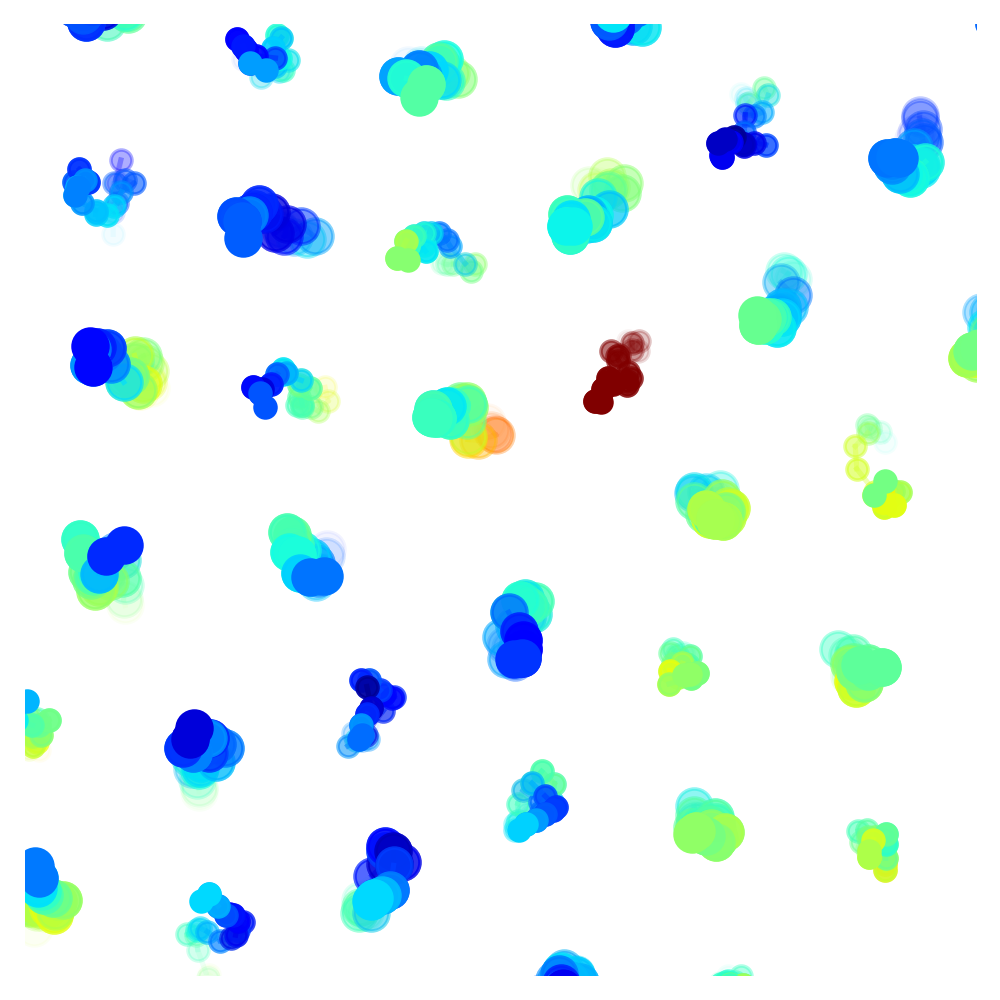

In [100]:
fig, ax = plt.subplots(dpi=251.75, figsize=(5, 5))
ax.set_aspect("equal")

cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=0.7)

z = orig_pos[2367]
L = 2.5
s = 20

old = glob.glob("images/hopv2-*.png")
for file in old:
    os.remove(file)

type_ids = snap.particles.typeid


# plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$|\Delta x|$")

for j in range(len(pose))[21:]:
    ax.clear()
    plt.axis('off')
    ax.margins(x=0)
    ax.margins(y=0)
    for i in np.arange(np.max([0, j-20]), j+1):
        alpha = 1 - (j - i) / 20
        
        diff = np.linalg.norm(pose[i, nlist2.point_indices] - pose[0, nlist2.point_indices], axis=-1)
        for k in range(len(nlist2.point_indices)):
            kdx = nlist2.point_indices[k]
            if type_ids[kdx] == 0:
                s = 20
            else:
                s = 12
            plt.plot(pose[i-1:i+1, nlist2.point_indices[k], 0], pose[i-1:i+1, nlist2.point_indices[k], 1], "-", marker=".",c=cmap(norm(diff[k])), alpha=alpha, markersize=s)
        if type_ids[2367] == 0:
            s = 20
        else:
            s = 12
        diff = np.linalg.norm(pose[i, 2367] - pose[0, 2367])
        plt.plot(pose[i-1:i+1, 2367, 0], pose[i-1:i+1, 2367, 1], "-", marker=".", alpha=alpha, c=cmap(norm(diff)), markersize=s)
    
    # plt.scatter(ref_pos[2367, 0], ref_pos[2367, 1], c=cmap(norm(i)))
    # ax = plt.gca()
    plt.xlim(z[0] - L, z[0] + L)
    plt.ylim(z[1] - L, z[1] + L)

    plt.savefig(f"images/hopv2-{i:03d}.png", bbox_inches="tight")
    


In [102]:
for j in range(len(pose))[21:30]:
    for i in np.arange(np.max([0, j-20]), j+1):
        alpha = 1 - (j - i) / 20
        print(alpha)

0.0
0.050000000000000044
0.09999999999999998
0.15000000000000002
0.19999999999999996
0.25
0.30000000000000004
0.35
0.4
0.44999999999999996
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
0.0
0.050000000000000044
0.09999999999999998
0.15000000000000002
0.19999999999999996
0.25
0.30000000000000004
0.35
0.4
0.44999999999999996
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
0.0
0.050000000000000044
0.09999999999999998
0.15000000000000002
0.19999999999999996
0.25
0.30000000000000004
0.35
0.4
0.44999999999999996
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
0.0
0.050000000000000044
0.09999999999999998
0.15000000000000002
0.19999999999999996
0.25
0.30000000000000004
0.35
0.4
0.44999999999999996
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
0.0
0.050000000000000044
0.09999999999999998
0.15000000000000002
0.19999999999999996
0.25
0.30000000000000004
0.35
0.4
0.44999999999999996
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
0.0
0.050000000000000044
0.09999999999999998
0.1500000000000

In [89]:
import ffmpeg
import os
output_file = "testv2.mp4"
if os.path.exists(output_file):
    os.remove(output_file)
(
ffmpeg
    .input("images/hopv2-*.png", pattern_type="glob", framerate=30)
    .output(output_file).run()
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


(None, None)

In [107]:
import ffmpeg
import os
output_file = "testv2-filet.mp4"
# input_file = ffmpeg.input("testv2.mp4")
input_file = ffmpeg.input("images/hopv2-*.png", pattern_type="glob", framerate=30)
cover = ffmpeg.input("/home/ian/drawing-best.png")
if os.path.exists(output_file):
    os.remove(output_file)
(
# ffmpeg
    input_file
    .overlay(cover)
    # .filter([input_file, cover], "overlay", 0, 0)
    .output(output_file, video_bitrate="20M")
    .run()
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


frame=  279 fps=156 q=-1.0 Lsize=   13318kB time=00:00:09.20 bitrate=11858.9kbits/s speed=5.15x    
video:13314kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.030197%
[libx264 @ 0x5e464352bb40] frame I:2     Avg QP: 1.39  size:120744
[libx264 @ 0x5e464352bb40] frame P:112   Avg QP: 1.28  size: 66891
[libx264 @ 0x5e464352bb40] frame B:165   Avg QP: 3.94  size: 35756
[libx264 @ 0x5e464352bb40] consecutive B-frames: 12.9% 17.9% 20.4% 48.7%
[libx264 @ 0x5e464352bb40] mb I  I16..4: 70.7%  2.8% 26.5%
[libx264 @ 0x5e464352bb40] mb P  I16..4:  1.8%  0.2%  2.8%  P16..4:  9.1%  2.7%  2.7%  0.0%  0.0%    skip:80.7%
[libx264 @ 0x5e464352bb40] mb B  I16..4:  0.7%  0.1%  0.9%  B16..8:  6.7%  1.8%  2.1%  direct: 4.4%  skip:83.4%  L0:41.7% L1:38.4% BI:19.9%
[libx264 @ 0x5e464352bb40] final ratefactor: -9.68
[libx264 @ 0x5e464352bb40] 8x8 transform intra:5.1% inter:23.4%
[libx264 @ 0x5e464352bb40] coded y,uvDC,uvAC intra: 36.3% 57.7% 56.5% inter: 9.5% 13.3% 13.2%
[libx

(None, None)

In [104]:
import ffmpeg
import os
output_file = "testv2-filet.avi"
# input_file = ffmpeg.input("testv2.mp4")
input_file = ffmpeg.input("images/hopv2-*.png", pattern_type="glob", framerate=30)
cover = ffmpeg.input("/home/ian/drawing-best.png")
if os.path.exists(output_file):
    os.remove(output_file)
(
# ffmpeg
    input_file
    .overlay(cover)
    # .filter([input_file, cover], "overlay", 0, 0)
    .output(output_file, video_bitrate=1000)
    .run()
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


frame=  279 fps=240 q=31.0 Lsize=    1202kB time=00:00:09.30 bitrate=1058.4kbits/s speed=7.99x    
video:1189kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.035591%


(None, None)